In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import math
from random import sample

In [81]:
def get_attribute(df, idx, attribute):
    return df.loc[idx][attribute]

def get_rating(df, user_idx, item_idx):
    return df.loc[user_idx].loc[item_idx]["rating:float"]

In [82]:
def plot_losses(df, user_info, item_info, sensitive_attributes):
    iterations = set(df["Iteration"])
    groups_info = {}
    
    if sensitive_attributes["user"]:
        if sensitive_attributes["item"]:
            split = "both"
        else:
            split = "user"
    else:
        split = "item"

    if split == "both":
        for u_group in set(user_info[sensitive_attributes["user"]]):
            if u_group == None:
                continue
            groups_info[u_group] = {}
            for i_group in set(item_info[sensitive_attributes["item"]]):
                if i_group == None:
                    continue
                groups_info[u_group][i_group] = {"indices": [], "losses": []}
                groups_info[u_group][i_group]["indices"].append(list(user_info[user_info[sensitive_attributes["user"]] == u_group].index))
                groups_info[u_group][i_group]["indices"].append(list(item_info[item_info[sensitive_attributes["item"]] == i_group].index))
    elif split == "user":
        for group in set(user_info[sensitive_attributes["user"]]):
            if group == None:
                continue
            groups_info[group] = {"losses": []}
            groups_info[group]["indices"] = list(user_info[user_info[sensitive_attributes["user"]] == group].index)
    elif split == "item":
        for group in set(item_info[sensitive_attributes["item"]]):
            if group == None:
                continue
            groups_info[group] = {"losses": []}
            groups_info[group]["indices"] = list(item_info[item_info[sensitive_attributes["item"]] == group].index)


    for i in iterations:
        iteration_df = df[df["Iteration"] == i]
        if split == "both":
            for u_group in groups_info.keys():
                for i_group in groups_info[u_group].keys():
                    u_indices, i_indices = groups_info[u_group][i_group]["indices"]
                    group_df = iteration_df[iteration_df["User ID"].isin(u_indices)]
                    group_df = group_df[group_df["Item ID"].isin(i_indices)]
                    groups_info[u_group][i_group]["losses"].append(group_df["Loss"])
        else:
            for group in groups_info.keys():
                if split == "user":
                    group_df = iteration_df[iteration_df["User ID"].isin(groups_info[group]["indices"])]
                elif split == "item":
                    group_df = iteration_df[iteration_df["Item ID"].isin(groups_info[group]["indices"])]
                groups_info[group]["losses"].append(group_df["Loss"])

    if split == "both":
        for u_group in groups_info.keys():
            for i_group in groups_info[u_group].keys():
                N = len(groups_info[u_group][i_group]["losses"][0])
                plt.plot(list(iterations)[:-11], [losses.mean() for losses in groups_info[u_group][i_group]["losses"]][:-11], label=f"User: {str(u_group)}, Item: {str(i_group)} (N = {N})")
    else:
        for group in groups_info.keys():
            N = len(groups_info[group]["losses"][0])
            plt.plot(list(iterations)[:-11], [losses.mean() for losses in groups_info[group]["losses"]][:-11], label=f"{group} (N = {N})")


    plt.title("BPR Loss over time for specific groups")
    plt.xlabel("Iteration")
    plt.ylabel("BPR Loss")
    plt.legend()
    plt.show()

In [83]:
# Loads the remappings made by the model during its training phase
with open("remappings/ml-1m.json") as f:
    remappings = json.load(f)

# Removes unneeded padding
del remappings["user_id"]["[PAD]"]
del remappings["item_id"]["[PAD]"]

# remappings is of the form {new_id: old_id} and can thus reverse the new ids
# Items without any rating were never assigned a new ID and thus are still the
# same without being reversed.
remappings = {alias: {int(v): int(k) for k, v in remappings[alias].items()} for alias in remappings.keys()}

In [ ]:
df_1m = pd.read_csv("ml-1m/tracking_data-1m-0001-128.csv", names=["Iteration", "User ID", "Item ID", "Predicted rating", "Loss"])

df_1m["User ID"] = df_1m["User ID"].map(remappings["user_id"])
df_1m["Item ID"] = df_1m["Item ID"].map(remappings["item_id"])

df_1m.head()

,Iteration,User ID,Item ID,Predicted rating,Loss
8,0,1,2321,0.005514,6.893382e-01
1988,0,1,608,-0.002927,6.954360e-01
21397,0,1,783,-0.003615,6.955804e-01
36308,0,1,2692,-0.002973,6.957868e-01
52256,0,1,1097,-0.003490,6.993712e-01
...,...,...,...,...,...
176277837,218,1,2762,5.573103,2.516229e-04
176278381,218,1,595,6.944147,3.009552e-03
176279409,218,1,2018,5.340871,4.234265e-03
176311195,218,1,531,5.296111,2.384186e-07


In [18]:
inter_info_1m = pd.read_csv("ml-1m/ratings.dat", sep="::", engine="python", encoding="latin-1", names=["user_id:token", "item_id:token", "rating:float", "timestamp:float"])

inter_info_1m.head()

,user_id:token,item_id:token,rating:float,timestamp:float
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [19]:
item_info_1m = pd.read_csv("ml-1m/movies.dat", sep="::", engine="python", encoding="latin-1", index_col=0, names=["item_id:token", "movie_title:token_seq", "class:token_seq"])
item_info_1m[["movie_title:token_seq", "release_year:token"]] = item_info_1m["movie_title:token_seq"].str.rsplit(" ", n=1, expand=True)
item_info_1m["release_year:token"] = item_info_1m["release_year:token"].str[1:-1]

# Stores all given ratings for each item
all_item_ratings = {}
for item_idx in item_info_1m.index:
    all_item_ratings[item_idx] = list(inter_info_1m[inter_info_1m["item_id:token"] == item_idx]["rating:float"])

# Average rating per item
item_info_1m["average rating"] = {item_idx: sum(all_item_ratings[item_idx]) / len(all_item_ratings[item_idx]) if len(all_item_ratings[item_idx]) >= 10 else None for item_idx in all_item_ratings.keys()}
# Positive item (avg rating > 3.8), negative item (avg rating < 2.8) or None
item_info_1m["pos/neg item"] = {item_idx: "pos" if item_info_1m.loc[item_idx]["average rating"] > 3.8 else "neg" if item_info_1m.loc[item_idx]["average rating"] < 2.8 else None for item_idx in all_item_ratings.keys()}
# Percentage of all ratings that belong to each item
item_info_1m["total ratings (%)"] = {item_idx: len(all_item_ratings[item_idx]) / len(inter_info_1m.index) for item_idx in all_item_ratings.keys()}

# Finds the most popular items that comprise 20% of the total amount of ratings (113 total)
pop_threshold = 0.2
cumulative_total = 0.0
pop_labels = {}
for i in item_info_1m.sort_values("total ratings (%)", ascending=False).index:
    if cumulative_total > pop_threshold:
        pop_labels[i] = 0
    else:
        cumulative_total += item_info_1m.loc[i]["total ratings (%)"]
        pop_labels[i] = 1

item_info_1m["popular item"] = pop_labels

item_info_1m.head()

,movie_title:token_seq,class:token_seq,release_year:token,average rating,pos/neg item,total ratings (%),popular item
item_id:token,,,,,,,
1,Toy Story,Animation|Children's|Comedy,1995,4.146846,pos,0.002077,1
2,Jumanji,Adventure|Children's|Fantasy,1995,3.201141,None,0.000701,0
3,Grumpier Old Men,Comedy|Romance,1995,3.016736,None,0.000478,0
4,Waiting to Exhale,Comedy|Drama,1995,2.729412,neg,0.000170,0
5,Father of the Bride Part II,Comedy,1995,3.006757,None,0.000296,0


In [61]:
user_info_1m = pd.read_csv("ml-1m/users.dat", sep="::", engine="python", index_col=0, names=["user_id:token", "gender:token", "age:token", "occupation:token", "zip_code:token"])

# Threshold for what fraction of a user's items should be popular for the user to be mainstream
user_pop_threshold = 0.25

# Stores all items each user has rated 
user_items = {user_idx: list(inter_info_1m[inter_info_1m["user_id:token"] == user_idx]["item_id:token"]) for user_idx in user_info_1m.index}
# Fraction of popular items rated by each user
user_info_1m["popular items rated (%)"] = {user_idx: item_info_1m.loc[user_items[user_idx]]["popular item"].sum() / len(user_items[user_idx]) for user_idx in user_info_1m.index}
# Whether a user is mainstream (1) or not (0) based on the threshold
user_info_1m["mainstream user"] = {user_idx: int(user_info_1m["popular items rated (%)"].loc[user_idx] >= user_pop_threshold) for user_idx in user_info_1m.index}

# Splits the users into mainstream classes based upon fraction of popular items rated by them (0-4, 4 means 40%+ popular items)
user_info_1m["mainstream class (thresholds)"] = {user_idx: math.floor(user_info_1m["popular items rated (%)"].loc[user_idx] * 10) for user_idx in user_info_1m.index}
user_info_1m.loc[user_info_1m["mainstream class (thresholds)"] > 4, "mainstream class (thresholds)"] = 4

# Assigns mainstream classes based on fraction thresholds (every 0.2 a new class)
N = 5
indices = user_info_1m.sort_values("popular items rated (%)", ascending=False).index
mainstream_classes = {}

for i in range(0, N):
    slices = (round(len(indices) / N * i), round(len(indices) / N * (i + 1)))
    for idx in user_info_1m.loc[indices[slices[0]: slices[1]]].index:
        mainstream_classes[idx] = (N - 1) - i

user_info_1m["mainstream class (even groups)"] = mainstream_classes

user_info_1m.head()

,gender:token,age:token,occupation:token,zip_code:token,popular items rated (%),mainstream user,mainstream class (thresholds),mainstream class (even groups)
user_id:token,,,,,,,,
1,F,1,10,48067,0.396226,1,3,4
2,M,56,16,70072,0.255814,1,2,2
3,M,25,15,55117,0.490196,1,4,4
4,M,45,7,02460,0.619048,1,4,4
5,M,25,20,55455,0.207071,0,2,1


In [ ]:
# plot_losses(df_1m, user_info_1m, item_info_1m, {"user": "gender:token", "item": None})
# plot_losses(df_1m, user_info_1m, item_info_1m, {"user": None, "item": "popular item"})
# plot_losses(df_1m, user_info_1m, item_info_1m, {"user": "gender:token", "item": "popular item"})

In [ ]:
# plot_losses(df_1m, user_info_1m, item_info_1m, {"user": None, "item": "pos/neg item"})
# plot_losses(df_1m, user_info_1m, item_info_1m, {"user": "mainstream user", "item": None})

In [ ]:
# plot_losses(df_1m, user_info_1m, item_info_1m, {"user": "mainstream class (thresholds)", "item": None})
# plot_losses(df_1m, user_info_1m, item_info_1m, {"user": "mainstream class (even groups)", "item": None})

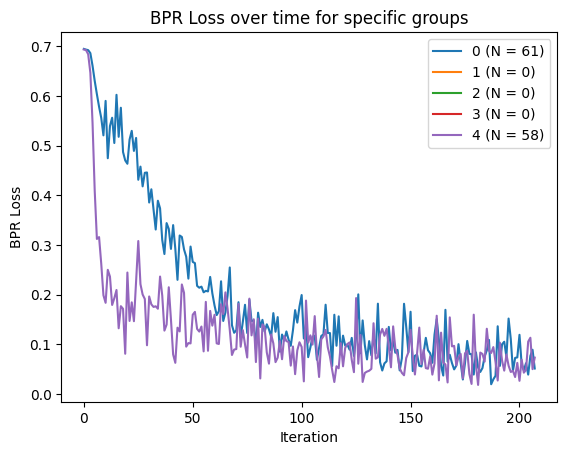

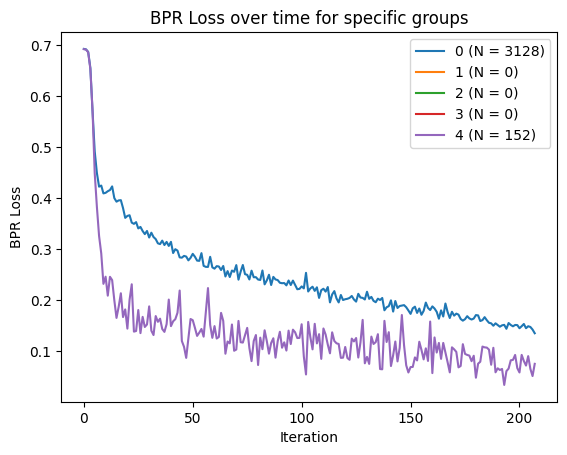

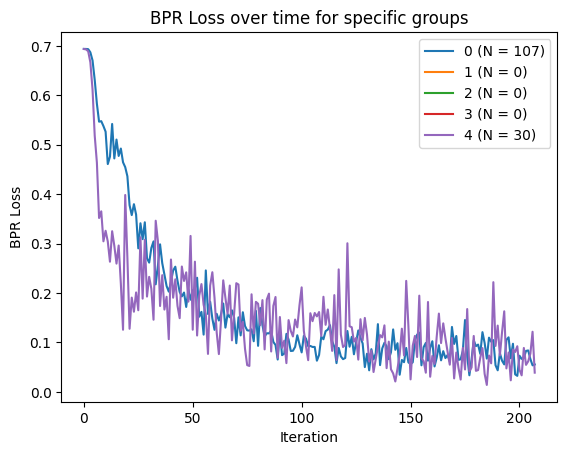

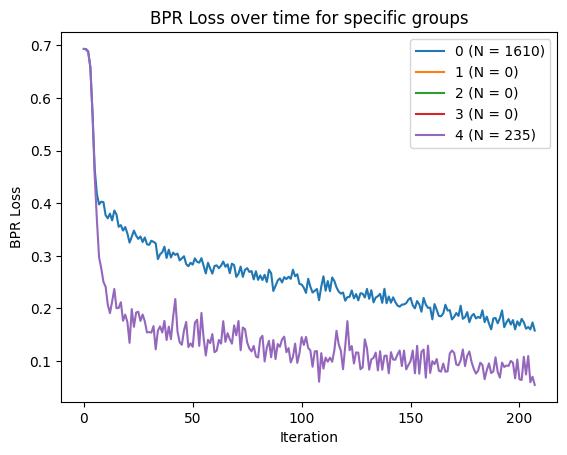

In [21]:
mainstream_1 = sample(list(user_info_1m[user_info_1m["mainstream class (thresholds)"] == 4].index), 1)
mainstream_5 = sample(list(user_info_1m[user_info_1m["mainstream class (thresholds)"] == 4].index), 5)
niche_1 = sample(list(user_info_1m[user_info_1m["mainstream class (thresholds)"] == 0].index), 1)
niche_5 = sample(list(user_info_1m[user_info_1m["mainstream class (thresholds)"] == 0].index), 5)

sample_1, sample_5 = mainstream_1 + niche_1, mainstream_5 + niche_5

plot_losses(df_1m[df_1m["User ID"].isin(sample_1)], user_info_1m, item_info_1m, {"user": "mainstream class (thresholds)", "item": None})
plot_losses(df_1m[df_1m["User ID"].isin(sample_5)], user_info_1m, item_info_1m, {"user": "mainstream class (thresholds)", "item": None})

mainstream_1 = sample(list(user_info_1m[user_info_1m["mainstream class (even groups)"] == 4].index), 1)
mainstream_5 = sample(list(user_info_1m[user_info_1m["mainstream class (even groups)"] == 4].index), 5)
niche_1 = sample(list(user_info_1m[user_info_1m["mainstream class (even groups)"] == 0].index), 1)
niche_5 = sample(list(user_info_1m[user_info_1m["mainstream class (even groups)"] == 0].index), 5)

sample_1, sample_5 = mainstream_1 + niche_1, mainstream_5 + niche_5

plot_losses(df_1m[df_1m["User ID"].isin(sample_1)], user_info_1m, item_info_1m, {"user": "mainstream class (even groups)", "item": None})
plot_losses(df_1m[df_1m["User ID"].isin(sample_5)], user_info_1m, item_info_1m, {"user": "mainstream class (even groups)", "item": None})